In [275]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

Recently, we introduced the gradient descent algorithm for solving the empirical risk minimization problem. We also calculated the gradient of the loss function for logistic regression.

In this blog post you will:

Implement gradient descent for logistic regression in an object-oriented paradigm.
Implement a key variant of gradient descent with momentum in order to achieve faster convergence.
Perform experiments to test your implementations.

# Part A: Implement Logistic Regression

## Implement ``LinearModel`` and ``LogisticRegression()``
If you haven’t already, implement the methods of the ``LinearModel`` class as described in this warmup. Then, define a new class called ``LogisticRegression`` which inherits from ``LinearModel``. This class should have two methods:

- ``LogisticRegression.loss(X, y)`` should compute the empirical risk $L(w)$ using the logistic loss function. The weight vector ``w`` used for this calculation should be stored as an instance variable of the class.

- ``LogisticRegression.grad(X, y)`` should compute the gradient of the empirical risk $L(w)$. You can use the formula for the gradient supplied in the lecture notes on gradient descent.

For an **M**, you can implement ``LogisticRegression.grad`` using a ``for``-loop. For an **E**, your solution should involve no explicit loops. While working on a solution that avoids loops, you might find it useful to at some point convert a tensor ``v`` with shape ``(n,)`` into a tensor ``v_`` with shape ``(n,1)``. The code ``v_ = v[:, None]`` will perform this conversion for you.

## Implement ``GradientDescentOptimizer``

Next, implement a ``GradientDescentOptimizer`` class. For this project, we are going to implement _gradient descent with momentum_, also known as Spicy Gradient Descent. Let w~k~ be the estimate of the weight vector at algorithmic step k. Gradient descent with momentum performs the update equation.

# Part B: Experiments

## Experimental Data


In [277]:
# TESTING
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X_rand, y_rand = classification_data(noise = 0.5)


## How to Train Your Model

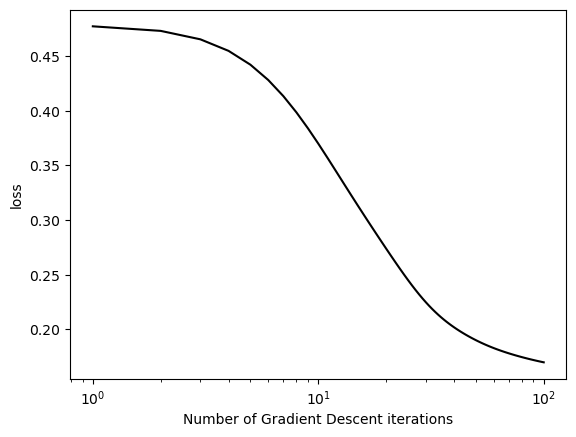

In [281]:
# TRAIN the model
from matplotlib import pyplot as plt

def train_and_plot(X, y, alpha, beta, iterations=100):

    LR = LogisticRegression() 
    opt = GradientDescentOptimizer(LR)

    loss_vec = []

    for _ in range(iterations):
       # add other stuff to e.g. keep track of the loss over time. 

        loss = LR.loss(X, y)
        loss_vec.append(loss)

        opt.step(X, y, alpha, beta)

    plt.plot(torch.arange(1, len(loss_vec) +1), loss_vec, color="black")
    plt.semilogx()
    labs = plt.gca().set(xlabel = "Number of Gradient Descent iterations", ylabel="loss")

train_and_plot(X_rand, y_rand, alpha=0.1, beta=0.9)

## Experiments

Please perform experiments, with careful written explanations, that demonstrate the following statements:

### 1. Vanilla gradient descent:
When the number of features $p~dim~=2$, when alpha is sufficiently small and beta=0, gradient descent for logistic regression converges to a weight vector `w` that looks visually correct (plot the decision boundary with the data). Furthermore, the loss decreases monotonically (plot the loss over iterations).
- This is a good experiment to use to assess whether your implementation in Part A has bugs.

In [291]:
X_exp, y_exp = classification_data(n_points = 300, noise = 0.2, p_dims = 2)

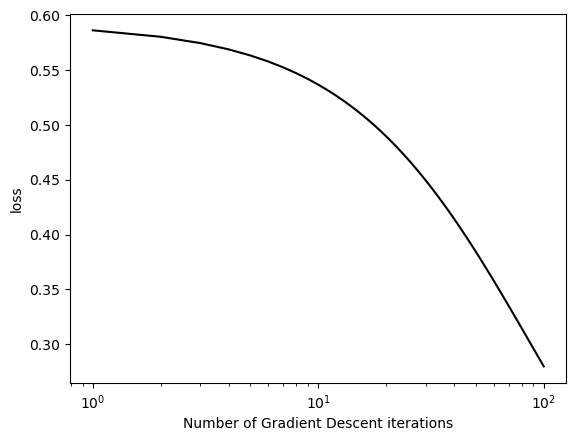

In [292]:
train_and_plot(X_exp, y_exp, 0.1, 0)

### 2. Benefits of momentum: 
On the same data, gradient descent with momentum (e.g. beta = 0.9) can converge to the correct weight vector in fewer iterations than vanilla gradient descent (with beta = 0). Plot the loss over iterations for each method. You may need to experiment with the data and choice of alpha in order to observe speedups due to momentum.

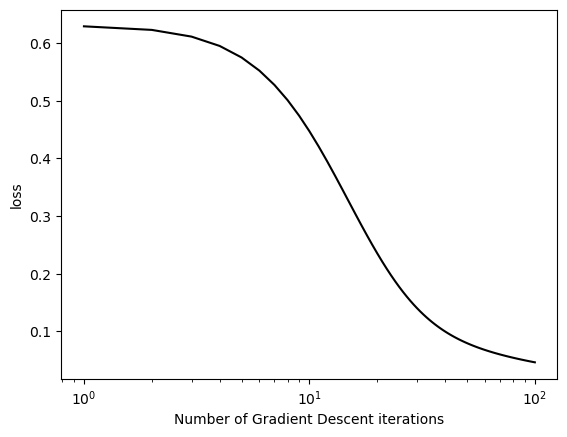

In [293]:
train_and_plot(X_exp, y_exp, 0.1, 0.9)

# Part C: Writing